In [3]:
url = '/content/drive/MyDrive/Alura/Cursos/3773 - TensorFlow Keras: Classificando imagens com redes convolucionais/Projeto/catarata'
import pathlib
data_dir=pathlib.Path(url)

batch_size = 32  # ou até 16, dependendo da memória disponível

altura = 224  # ou 256
largura = 224  # ou 256

In [4]:
import tensorflow as tf

Found 410 files belonging to 2 classes.
Using 328 files for training.
Found 410 files belonging to 2 classes.
Using 82 files for validation.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 100s 8s/step - accuracy: 0.5548 - loss: 3.6858 - val_accuracy: 0.5732 - val_loss: 2.1665
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 79s 7s/step - accuracy: 0.7235 - loss: 1.2375 - val_accuracy: 0.9512 - val_loss: 0.1468
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 80s 7s/step - accuracy: 0.9015 - loss: 0.3198 - val_accuracy: 0.9878 - val_loss: 0.0985
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 82s 8s/step - accuracy: 0.9072 - loss: 0.1836 - val_accuracy: 0.9024 - val_loss: 0.2039
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 136s 7s/step - accuracy: 0.9256 - loss: 0.1943 - val_accuracy: 1.0000 - val_loss: 0.0520
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 88s 8s/step - accuracy: 0.9664 - loss: 0.0782 - val_accuracy: 0.9756 - val_loss: 0.0664
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 83s 8s/step 

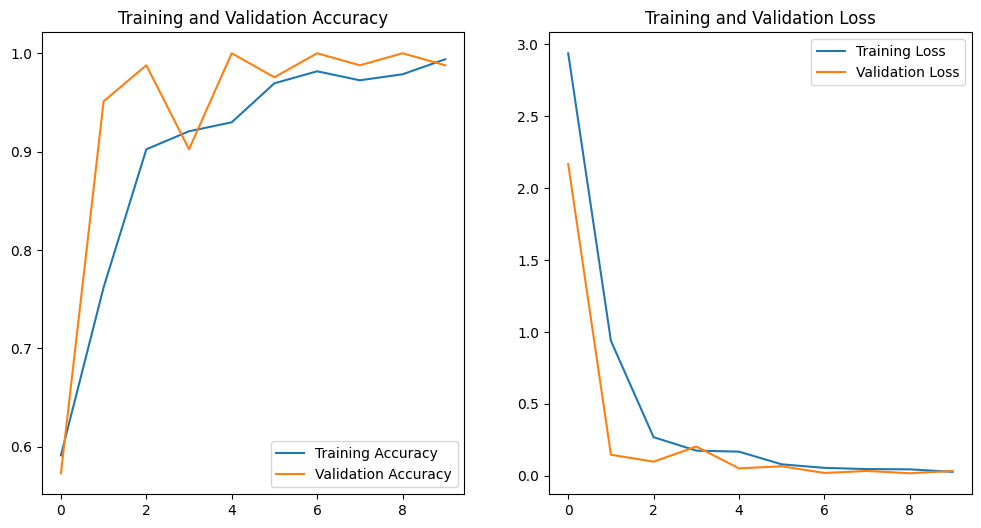

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


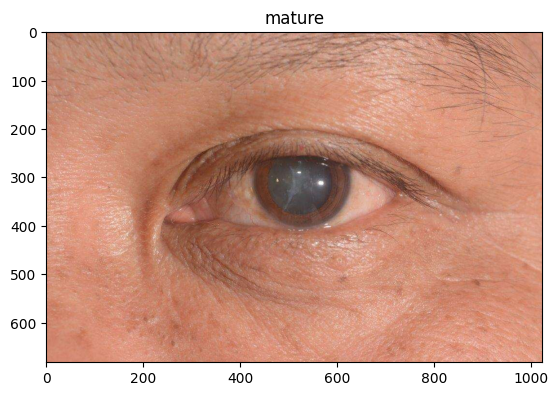

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


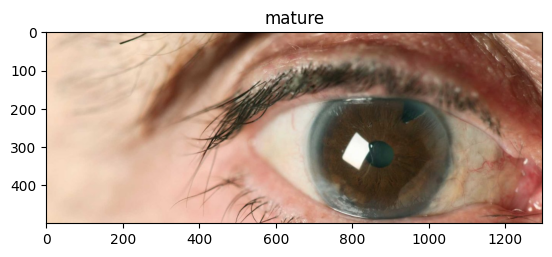

In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Carregar os dados
#data_dir = '/path/to/cataract-classification-dataset/train'

train_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

val_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

# Classes
class_names = train_dataset.class_names

# Data augmentation
data_augmentation = Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
])

# Aplicar data augmentation
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

# Construir o modelo com ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congelar as camadas convolucionais

model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compilar o modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Treinar o modelo
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

# Função para plotar resultados
def plot_training_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Plotar resultados
plot_training_results(history)

# Inferência em novas imagens
from tensorflow.keras.preprocessing import image
from PIL import Image
import requests
import io

def infer(img_url):
    response = requests.get(img_url)
    img = Image.open(io.BytesIO(response.content))
    plt.imshow(img)
    img = img.resize((224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class = 'mature' if prediction[0] > 0.5 else 'immature'

    plt.title(predicted_class)
    plt.show()



2/3 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step  

3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step


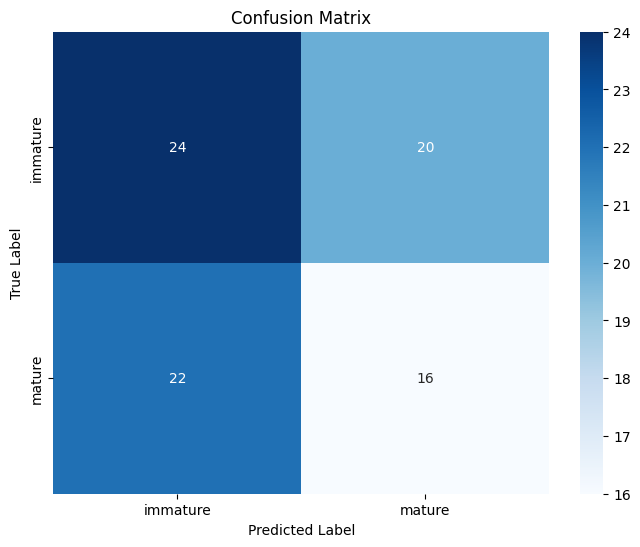

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Previsões do modelo para todos os dados de validação
y_pred = (model.predict(validacao) > 0.5).astype(int)

# Obter rótulos verdadeiros do dataset de validação
y_true = np.concatenate([y for x, y in validacao], axis=0)

# Gerar a matriz de confusão
cm = confusion_matrix(y_true, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()
